In [1]:
# Retrain based on the model saved from Project-BERT

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import torch 
from torch import nn
from torch.utils.data import DataLoader, Dataset, TensorDataset, SequentialSampler
import tqdm
from transformers import BertForSequenceClassification, AdamW, BertTokenizer, BertModel
from sklearn.preprocessing import LabelEncoder

/home/jz3502/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:471: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/jz3502/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:472: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/jz3502/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:473: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/jz3502/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:474: 

In [6]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case = True)

In [2]:
bert = BertModel.from_pretrained('bert-base-cased', output_attentions=True)

In [7]:
bert.embeddings.word_embeddings = nn.Embedding(tokenizer.vocab_size, 768, padding_idx = 0)

In [8]:
# # Split the sequence in half and then tokenize seperately

# def bert_tokenize(data, max_length, label_dict):
    
#     input_ids_first = []
#     input_ids_second = []
#     attention_masks_first = []
#     attention_masks_second = []
#     labels = []
    
#     for sentence in data['TEXT']:
#         text_len = len(sentence)

#         encoded_dict_first = tokenizer.encode_plus(sentence[:text_len//2], add_special_tokens = True, max_length = max_length,\
#                                              pad_to_max_length = True, return_attention_mask = True, return_tensors = 'pt')
#         input_ids_first.append(encoded_dict_first['input_ids'])
#         attention_masks_first.append(encoded_dict_first['attention_mask'])
   
        
#         encoded_dict_second = tokenizer.encode_plus(sentence[text_len//2:], add_special_tokens = True, max_length = max_length,\
#                                              pad_to_max_length = True, return_attention_mask = True, return_tensors = 'pt')
#         input_ids_second.append(encoded_dict_second['input_ids'])
#         attention_masks_second.append(encoded_dict_second['attention_mask'])
        
#     for codes in data['ICD9_CODE_1k']:
#         label = [0]*1000
        
#         all_code = codes.split(',')
#         for code in all_code:
#             label[label_dict[code]] = 1
        
#         labels.append(torch.tensor(label))


        
#     input_ids_first = torch.cat(input_ids_first, dim=0)
#     attention_masks_first = torch.cat(attention_masks_first, dim=0)
#     input_ids_second = torch.cat(input_ids_second, dim=0)
#     attention_masks_second = torch.cat(attention_masks_second, dim=0)
#     labels = torch.stack(labels, dim=0)
        
#     return input_ids_first, attention_masks_first, input_ids_second, attention_masks_second, labels

In [9]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [10]:
train_loader_bert = torch.load('train_dataloader.pth')
val_loader_bert = torch.load('val_dataloader.pth')
test_loader_bert = torch.load('test_dataloader.pth')

In [11]:
# Train first and second half of the sequence seperately, then concatenate the hidden state output

class BERTClassifier(nn.Module):
    def __init__(self, bert, num_classes):
        super().__init__()
        self.bert = bert
        self.linear = nn.Linear(bert.config.hidden_size*2, num_classes)
        self.num_classes = num_classes
    
    def forward(self, input_ids_first, attention_masks_first, input_ids_second, attention_masks_second):
        h1, _, _ = self.bert(input_ids = input_ids_first, attention_mask = attention_masks_first)
        h1_cls = h1[:, 0]
        h2, _, _ = self.bert(input_ids = input_ids_second, attention_mask = attention_masks_second)
        h2_cls = h2[:, 0]
        h_cls = torch.cat((h1_cls, h2_cls), dim = -1)
        logits = self.linear(h_cls)
        return logits

In [6]:
model_bert = torch.load('model.pt').to(device)

In [7]:
criterion = nn.BCEWithLogitsLoss(reduction = 'sum')
optimizer_bert = AdamW(model_bert.parameters(), lr = 1e-5)

In [9]:
train_loss_list_bert = []
val_loss_list_bert = []

for epoch in range(5):
    print("current epoch is "+str(epoch))
    train_loss = 0
    train_correct = 0
    train_total = 0
    val_loss = 0
    val_correct = 0
    val_total = 0
    model_bert.train()
    for i, (input_ids_first, attention_masks_first, input_ids_second,
            attention_masks_second, labels) in enumerate(train_loader_bert):
        
        optimizer_bert.zero_grad()
        input_ids_first = input_ids_first.to(device)
        attention_masks_first = attention_masks_first.to(device)
        input_ids_second = input_ids_second.to(device)
        attention_masks_second = attention_masks_second.to(device)
        labels = labels.to(device).float()

        
        
        logits = model_bert(input_ids_first, attention_masks_first, input_ids_second, attention_masks_second)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer_bert.step()
        
        train_loss += loss.item()
        train_total += input_ids_first.size()[0]
        
    train_avg_loss = train_loss / train_total   
    train_loss_list_bert.append(train_avg_loss)
    
    model_bert.eval()
    with torch.no_grad():
        for i, (input_ids_first, attention_masks_first, input_ids_second,
                attention_masks_second, labels) in enumerate(val_loader_bert):
        
            input_ids_first = input_ids_first.to(device)
            attention_masks_first = attention_masks_first.to(device)
            input_ids_second = input_ids_second.to(device)
            attention_masks_second = attention_masks_second.to(device)
            labels = labels.to(device).float()

            logits = model_bert(input_ids_first, attention_masks_first, input_ids_second, attention_masks_second)
            loss = criterion(logits, labels)

            val_loss += loss.item()
            val_total += input_ids_first.size()[0]       
        

    val_avg_loss = val_loss / val_total  
    val_loss_list_bert.append(val_avg_loss)

current epoch is 0
current epoch is 1
current epoch is 2
current epoch is 3
current epoch is 4


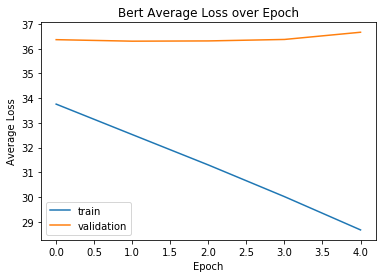

In [10]:
plt.plot(np.arange(5), train_loss_list_bert, label = 'train')
plt.plot(np.arange(5), val_loss_list_bert, label = 'validation')
plt.legend()
plt.title('Bert Average Loss over Epoch')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.savefig('loss_retrain.jpg')

In [11]:
torch.save(model_bert, 'model_retrain.pt')

/home/jz3502/.local/lib/python3.5/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type BERTClassifier. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [12]:
# model_bert = torch.load('model_retrain.pt').to(device)

In [12]:
test_label = []
test_logits = []
test_prediction = []

model_bert.eval()
with torch.no_grad():
    for i, (input_ids_first, attention_masks_first, input_ids_second,
            attention_masks_second, labels) in enumerate(test_loader_bert):

        input_ids_first = input_ids_first.to(device)
        attention_masks_first = attention_masks_first.to(device)
        input_ids_second = input_ids_second.to(device)
        attention_masks_second = attention_masks_second.to(device)
        labels = labels.to(device).float()

        logits = model_bert(input_ids_first, attention_masks_first, input_ids_second, attention_masks_second)
        sigmoid_logits = torch.sigmoid(logits)
        prediction = torch.where(sigmoid_logits > 0.5, torch.tensor(1).to(device), torch.tensor(0).to(device))
        
        test_label.extend(labels.tolist())
        test_logits.extend(logits.tolist())
        test_prediction.extend(prediction.tolist())

In [13]:
test_label_array = np.array(test_label)
test_logits_array = np.array(test_logits)
test_prediction_array = np.array(test_prediction)

In [14]:
# Show precision and recall (at 10 and at 5)

from sklearn.metrics import precision_score, recall_score

In [15]:
# At 10

label_at_10 = []
prediction_at_10 = []

top_10 = test_logits_array.argsort(axis = 1)[:,-10:]
for row,top in enumerate(top_10):
    test_label_top = test_label_array[row][top]
    test_prediction_top = test_prediction_array[row][top]

    label_at_10.extend(test_label_top)
    prediction_at_10.extend(test_prediction_top)
    

In [16]:
precision_at_10 = precision_score(label_at_10, prediction_at_10)
recall_at_10 = recall_score(label_at_10, prediction_at_10)

In [17]:
print(precision_at_10)
print(recall_at_10)

0.8336921479700563
0.622743394978837


In [18]:
# At 5

label_at_5 = []
prediction_at_5 = []

top_5 = test_logits_array.argsort(axis = 1)[:,-5:]
for row,top in enumerate(top_5):
    test_label_top = test_label_array[row][top]
    test_prediction_top = test_prediction_array[row][top]

    label_at_5.extend(test_label_top)
    prediction_at_5.extend(test_prediction_top)

In [19]:
precision_at_5 = precision_score(label_at_5, prediction_at_5)
recall_at_5 = recall_score(label_at_5, prediction_at_5)

In [20]:
print(precision_at_5)
print(recall_at_5)

0.8595529807805222
0.7974072191154041
